In [1]:
# Standard Libraries
import os

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Machine Learning Models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preprocessing and Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Hyperparameter Distributions
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Joblib for Model Saving and Loading
from joblib import dump, load
import joblib

# Data Preprocessing

In [2]:
# Load the data
data = pd.read_csv('clarityAI_data.csv')

#### Log Transformation

In [3]:
# Log transformation
data['co2directscope1_raw'] = np.log1p(data['co2directscope1_raw'])
data['revenue'] = np.log1p(data['revenue'])

C:\Users\user1\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Missing Data Imputation (Backfill)
This method imputes missing values using the subsequent year's value for the same company.

In [4]:
# Sort the data by 'clarity_id' and 'metric_year'
data = data.sort_values(by=['clarity_id', 'metric_year'])

# Perform backfill on the 'revenue' column within each 'clarity_id' group
data['revenue'] = data.groupby('clarity_id')['revenue'].bfill()

#### Dropping Irrelevant/Redundant Columns

In [5]:
# Dropping columns 
X = data.drop(columns=['metric', 'co2directscope1_raw', 'clarity_industry_code', 'co2directscope1_intensity'])
y = data['co2directscope1_raw']

#### Preprocessor for One-Hot Encoding
All categorical features will be transformed using a one-hot encoder.

In [6]:
# Defining numerical and catagorical features
numerical_features = ['revenue']
categorical_features = [
    'clarity_id', 'provider_code', 
    'clarity_industry_name', 'country_code', 'targets_emissions', 
    'policy_emissions', 'sbti_alignment', 'nz_statement', 'metric_year'
]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the two pipelines above
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Ensemble Models Using One-Hot Encoded Data

In [7]:
trained_models_one_hot = {}

# Create the models dictionary
models = {
    'Random Forest Regressor': RandomForestRegressor(random_state=2024),
    'LightGBM Regressor': LGBMRegressor(random_state=2024),
    'XGBoost Regressor': XGBRegressor(random_state=2024),
    'CatBoost Regressor': CatBoostRegressor(verbose=False, random_state=2024)
}

#### Function to Build Model Pipeline

In [8]:
# Create a function to build the model pipeline
def build_model(model):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    return pipeline

#### Function to Evaluate Models

In [9]:
# Function to evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    y_train_pred = np.expm1(y_train_pred_log)
    y_test_pred = np.expm1(y_test_pred_log)
    y_train_orig = np.expm1(y_train)
    y_test_orig = np.expm1(y_test)
    
    train_mae = mean_absolute_error(y_train_orig, y_train_pred)
    train_mse = mean_squared_error(y_train_orig, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_orig, y_train_pred)
    
    test_mae = mean_absolute_error(y_test_orig, y_test_pred)
    test_mse = mean_squared_error(y_test_orig, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_orig, y_test_pred)
    
    return train_mae, train_mse, train_rmse, train_r2, test_mae, test_mse, test_rmse, test_r2

#### Parameter Distribution

In [10]:
# Parameter distributions for RandomizedSearchCV
param_distributions = {
    'Random Forest Regressor': {
        'regressor__n_estimators': sp_randint(100, 500),
        'regressor__max_features': ['sqrt', 'log2'],
        'regressor__max_depth': sp_randint(5, 15),
        'regressor__min_samples_split': sp_randint(2, 6),
        'regressor__min_samples_leaf': sp_randint(1, 5)
    },
    'LightGBM Regressor': {
        'regressor__n_estimators': sp_randint(100, 500),
        'regressor__learning_rate': sp_uniform(0.01, 0.1),
        'regressor__num_leaves': sp_randint(20, 35),
        'regressor__boosting_type': ['gbdt', 'dart']
    },
    'XGBoost Regressor': {
        'regressor__n_estimators': sp_randint(100, 500),
        'regressor__learning_rate': sp_uniform(0.01, 0.1),
        'regressor__max_depth': sp_randint(5, 15),
        'regressor__subsample': sp_uniform(0.7, 0.3),
        'regressor__colsample_bytree': sp_uniform(0.7, 0.3)
    },
    'CatBoost Regressor': {
    'regressor__iterations': sp_randint(100, 500),
    'regressor__depth': sp_randint(4, 10),
    'regressor__learning_rate': sp_uniform(0.01, 0.2),
    'regressor__l2_leaf_reg': sp_uniform(1, 10)
    }

}

#### Split Data Into Training and Test Sets

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

#### Model Training (One-Hot Encoded Data)

In [12]:
results = {}

for model_name, model in models.items():
    pipeline = build_model(model)
    param_dist = param_distributions[model_name]

    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, verbose=1, n_jobs=-1, random_state=2024)
    search.fit(X_train, y_train)
    
    # Store best model
    trained_models_one_hot[model_name] = search.best_estimator_
    
    # Performance metrics
    train_mae, train_mse, train_rmse, train_r2, test_mae, test_mse, test_rmse, test_r2 = evaluate_model(search.best_estimator_, X_train, y_train, X_test, y_test)

    results[model_name] = {
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'best_params': search.best_params_
    }


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 14626, number of used features: 193
[LightGBM] [Info] Start training from score 17.082320
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### Model Evaluation

In [13]:
# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

                                train_mae              train_mse  \
Random Forest Regressor  677272764.582352  7628548426745659392.0   
LightGBM Regressor       276538892.651059  3180761267367272448.0   
XGBoost Regressor        182661717.579541  2145169811173096448.0   
CatBoost Regressor       286654220.121903  3147759913253947904.0   

                                train_rmse  train_r2          test_mae  \
Random Forest Regressor  2761982698.487748 -0.040091  664538883.579888   
LightGBM Regressor       1783468886.010427  0.566329  316962267.337269   
XGBoost Regressor        1464639823.018989  0.707523  204747442.499355   
CatBoost Regressor       1774192749.746754  0.570828  294317226.612657   

                                      test_mse          test_rmse   test_r2  \
Random Forest Regressor  6061077713559607296.0  2461925610.890712  -0.04778   
LightGBM Regressor       1889075920560010496.0  1374436582.953179  0.673435   
XGBoost Regressor         739381479906337408.0   85

In [14]:
def get_feature_importances(trained_model, model_name, numerical_features, categorical_features):
    # Access the preprocessor and the ColumnTransformer
    preprocessor = trained_model.named_steps['preprocessor']

    # Access the numerical and categorical feature names
    num_features = numerical_features
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

    # Combine numerical and categorical feature names
    feature_names = np.concatenate([num_features, cat_features])

    # Extract feature importances from the model
    importances = trained_model.named_steps['regressor'].feature_importances_

    # DataFrame for the feature importances
    return pd.DataFrame({'Feature': feature_names, model_name: importances})

# Define numerical and categorical features
numerical_features = ['revenue']
categorical_features = [
    'clarity_id', 'provider_code', 
    'clarity_industry_name', 'country_code', 'targets_emissions', 
    'policy_emissions', 'sbti_alignment', 'nz_statement', 'metric_year'
]

# Models to process
models_one_hot = {
    'Random Forest Regressor': trained_models_one_hot['Random Forest Regressor'],
    'LightGBM Regressor': trained_models_one_hot['LightGBM Regressor'],
    'XGBoost Regressor': trained_models_one_hot['XGBoost Regressor'],
    'CatBoost Regressor': trained_models_one_hot['CatBoost Regressor']
}

# Initialize an empty DataFrame to store all feature importances
all_feature_importances = pd.DataFrame()

# Loop through each model to get and merge feature importances
for model_name, model in models_one_hot.items():
    feature_importances = get_feature_importances(model, model_name, numerical_features, categorical_features)
    if all_feature_importances.empty:
        all_feature_importances = feature_importances
    else:
        all_feature_importances = all_feature_importances.merge(feature_importances, on='Feature', how='outer')

# Fill NaN values with 0 for missing importances
all_feature_importances = all_feature_importances.fillna(0)
all_feature_importances


,Feature,Random Forest Regressor,LightGBM Regressor,XGBoost Regressor,CatBoost Regressor
0,revenue,1.401602e-01,4282,0.000945,15.110790
1,clarity_id_01FF543RDSJ38V7QW07J4M7ZAG,0.000000e+00,0,0.001701,0.020827
2,clarity_id_01FF543RDVV1QPSXGA7PMQ8RAV,2.353996e-06,0,0.000089,0.000000
3,clarity_id_01FF543RE2PM00TVYCDWZ0E18Q,1.296700e-07,0,0.000049,0.000000
4,clarity_id_01FF543RE5NZ3QGF5AP27JWSR9,5.503277e-04,0,0.000084,0.000861
...,...,...,...,...,...
1611,metric_year_2018,1.214493e-04,21,0.000044,0.071485
1612,metric_year_2019,1.606901e-04,39,0.000049,0.103734
1613,metric_year_2020,1.015358e-04,25,0.000054,0.051860
1614,metric_year_2021,7.934447e-05,30,0.000063,0.062466


# Preparing Dataset with Target Encoding and Additional Feature Engineering
- **Handling High Cardinality:** To manage the high cardinality in categorical features such as company, industry, and country, target encoding is applied. This method is executed exclusively on the training data to prevent data leakage, ensuring that the test data does not inadvertently affect the feature values derived during training.
- **Encoding Less Complex Categories:** For categorical features that exhibit fewer categories, one-hot encoding remains our method of choice.
- **Enhancing Predictive Features:** To improve the dataset's analytical capabilities, Year-over-Year Percent Changes for CO2 Emissions and Revenue at the company level are calculated. This addition is designed to capture significant temporal trends within each company, thereby improving our model's ability to predict accurately.


#### Feature Engineering with Industry-Level Aggregated Metrics (Target Encoding)

In [15]:
# Split the data to apply the transformation on only training data to prevent data leakage
train_data, test_data = train_test_split(data, test_size=0.2, random_state=2024)

# Aggregated features based on clarity_industry_name (industry-level) on training data
train_data['industry_co2_mean'] = train_data.groupby('clarity_industry_name')['co2directscope1_raw'].transform('mean')
train_data['industry_co2_std'] = train_data.groupby('clarity_industry_name')['co2directscope1_raw'].transform('std')
train_data['industry_revenue_mean'] = train_data.groupby('clarity_industry_name')['revenue'].transform('mean')
train_data['industry_revenue_std'] = train_data.groupby('clarity_industry_name')['revenue'].transform('std')

# Merge the aggregated features calculated from the training data into the test data
test_data = test_data.merge(
    train_data[['clarity_industry_name', 'industry_co2_mean', 'industry_co2_std', 'industry_revenue_mean', 'industry_revenue_std']].drop_duplicates(),
    on='clarity_industry_name',
    how='left'
)

#### Feature Engineering with Country-Level Aggregated Metrics (Target Encoding)

In [16]:
# Aggregated features based on country_code (country-level) on training data
train_data['country_co2_mean'] = train_data.groupby('country_code')['co2directscope1_raw'].transform('mean')
train_data['country_co2_std'] = train_data.groupby('country_code')['co2directscope1_raw'].transform('std')
train_data['country_revenue_mean'] = train_data.groupby('country_code')['revenue'].transform('mean')
train_data['country_revenue_std'] = train_data.groupby('country_code')['revenue'].transform('std')

# Merge the aggregated features calculated from the training data into the test data
test_data = test_data.merge(
    train_data[['country_code', 'country_co2_mean', 'country_co2_std', 'country_revenue_mean', 'country_revenue_std']].drop_duplicates(),
    on='country_code',
    how='left'
)

#### Feature Engineering with Company-Level Aggregated Metrics (Target Encoding)

In [17]:
# Aggregated features based on clarity_id (company-level) on training data
train_data['company_co2_mean'] = train_data.groupby('clarity_id')['co2directscope1_raw'].transform('mean')
train_data['company_co2_std'] = train_data.groupby('clarity_id')['co2directscope1_raw'].transform('std')
train_data['company_revenue_mean'] = train_data.groupby('clarity_id')['revenue'].transform('mean')
train_data['company_revenue_std'] = train_data.groupby('clarity_id')['revenue'].transform('std')

# Merge the aggregated features calculated from the training data into the test data
test_data = test_data.merge(
    train_data[['clarity_id', 'company_co2_mean', 'company_co2_std', 'company_revenue_mean', 'company_revenue_std']].drop_duplicates(),
    on='clarity_id',
    how='left'
)

#### Year-over-Year Percent Change for CO2 Emissions and Revenue at the Company-Level

In [18]:
# Year-over-Year Percent Change for CO2 Emissions and Revenue (company-level)
train_data = train_data.sort_values(by=['clarity_id', 'metric_year'])
train_data['co2_percent_change'] = train_data.groupby('clarity_id')['co2directscope1_raw'].pct_change()
train_data['revenue_percent_change'] = train_data.groupby('clarity_id')['revenue'].pct_change()

# Merge the aggregated features calculated from the training data into the test data
test_data = test_data.sort_values(by=['clarity_id', 'metric_year'])
test_data['co2_percent_change'] = test_data.groupby('clarity_id')['co2directscope1_raw'].pct_change()
test_data['revenue_percent_change'] = test_data.groupby('clarity_id')['revenue'].pct_change()

# Combine training and test data to apply further transformations
data = pd.concat([train_data, test_data], ignore_index=True)

#### Missing Values in Percent Changes Features

In [19]:
data[data.isna().any(axis=1)] # 2648 missing

,clarity_id,metric,metric_year,provider_code,clarity_industry_code,clarity_industry_name,country_code,co2directscope1_raw,revenue,co2directscope1_intensity,...,country_co2_mean,country_co2_std,country_revenue_mean,country_revenue_std,company_co2_mean,company_co2_std,company_revenue_mean,company_revenue_std,co2_percent_change,revenue_percent_change
0,01FF543RDSJ38V7QW07J4M7ZAG,CO2DIRECTSCOPE1,2005,TRC1,20102010/0,Building Products,FR,21.148065,15.371795,322.553852,...,17.556078,2.838176,14.342845,1.261382,21.012830,0.223910,15.534727,0.084623,NaN,NaN
13,01FF543RDVV1QPSXGA7PMQ8RAV,CO2DIRECTSCOPE1,2011,TRC1,15101040/0,Industrial Gases,JP,18.406105,12.882029,250.655294,...,17.485919,2.327973,13.730494,1.107453,18.438391,0.122099,13.397223,0.359377,NaN,NaN
23,01FF543RE2PM00TVYCDWZ0E18Q,CO2DIRECTSCOPE1,2011,TRC1,45202030/0,"Technology Hardware, Storage & Peripherals",JP,14.988800,12.945704,7.714469,...,17.485919,2.327973,13.730494,1.107453,15.231798,0.448455,13.302248,0.329066,NaN,NaN
29,01FF543RE5NZ3QGF5AP27JWSR9,CO2DIRECTSCOPE1,2005,TRC1,55100000/1,Electricity generation utilities,GB,21.811215,13.973792,2533.668066,...,15.742036,2.775746,12.742188,1.728158,21.314219,0.524023,14.874922,0.639125,NaN,NaN
43,01FF543RE66KYZPSXQSCE4PWA4,CO2DIRECTSCOPE1,2012,TRC1,45102010/0,IT Consulting & Other Services,FI,7.098923,12.414950,0.004908,...,16.347590,3.304561,13.281614,0.931729,10.749295,1.734587,12.422610,0.251131,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18264,01FF543WQKD1MCRHRA1RRDNTX9,CO2DIRECTSCOPE1,2007,TRC1,10102010/0,Integrated Oil & Gas,FR,22.712139,16.732002,395.494530,...,17.556078,2.838176,14.342845,1.261382,22.476041,0.244041,16.748256,0.240961,NaN,NaN
18269,01FF543WR4R2W4HAYCBNRZBG0J,CO2DIRECTSCOPE1,2015,TRC1,25101020/0,Tires & Rubber,FI,15.933945,12.120877,45.289415,...,16.347590,3.304561,13.281614,0.931729,15.984907,0.271713,12.247207,0.111657,NaN,NaN
18272,01FF543WRA4NWGB5RDFFW1T1NZ,CO2DIRECTSCOPE1,2012,TRC1,35202010/0,Pharmaceuticals,IL,17.695619,14.747534,19.069399,...,18.629339,0.919150,13.977771,0.552078,17.557405,0.206124,14.594254,0.145076,NaN,NaN
18276,01GP4TPBYZ7JHGVV8HJ8FQVC9X,CO2DIRECTSCOPE1,2010,TRC8,00000000/0,CLARITY DEFAULT,GB,18.222139,15.393489,16.922600,...,15.742036,2.775746,12.742188,1.728158,18.614923,0.271358,16.215046,0.291679,NaN,NaN


# Random Forest: Imputation For Missing Values in "co2_percent_change" due to gap years for company-level. 

#### Feature Selection
We will use target-encoded features to represent categories with many levels, and drop the original categorical variables.  Additionally, we will omit `co2directscope1_raw` and `co2directscope1_intensity` from our training model, as these features are absent in our validation dataset, ensuring consistency in model application.

In [20]:
# Select relevant features for prediction
features = data.drop(columns=['clarity_id', 'metric', 'clarity_industry_code', 'clarity_industry_name', 
                             'country_code', 'co2directscope1_raw', 'co2directscope1_intensity',
                             'co2_percent_change', 'revenue_percent_change'])

#### Data Splitting Strategy
We are dividing the dataset based on the `co2_percent_change` feature into two subsets: one where this variable is known (not NaN) and another where it is unknown (NaN). We will further split the subset with known values into training and testing groups for model evaluation. Later, we will use the model to predict and impute the unknown values. This same process is done with `revenue_percent_change` feature.

In [21]:
# Separate the entries with known and unknown CO2 percent changes
known_co2 = data[data['co2_percent_change'].notna()]
unknown_co2 = data[data['co2_percent_change'].isna()]

# For CO2 percent change
X_co2 = known_co2[features.columns]
y_co2 = known_co2['co2_percent_change']
X_train_co2, X_test_co2, y_train_co2, y_test_co2 = train_test_split(X_co2, y_co2, test_size=0.2, random_state=2024)

# Separate the entries with known and unknown revenue percent changes
known_revenue = data[data['revenue_percent_change'].notna()]
unknown_revenue = data[data['revenue_percent_change'].isna()]

# For Revenue percent change
X_revenue = known_revenue[features.columns]
y_revenue = known_revenue['revenue_percent_change']
X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X_revenue, y_revenue, test_size=0.2, random_state=2024)

### Preprocessor Definition
Setting up the preprocessor for categorical feature one-hot encoding before model training.

In [22]:
# Define the preprocessor to handle categorical data
categorical_features = [
    'provider_code', 'targets_emissions', 'policy_emissions', 
    'sbti_alignment', 'nz_statement', 'metric_year'
]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### Training the Random Forest Model

In [23]:
# Define Random Forest parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(50, 501, 50),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(5, 51, 5)),
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

In [24]:
# Function to train and evaluate a Random Forest model for imputation
def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(random_state=2024)
    random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=50, cv=5, verbose=1, random_state=2024, n_jobs=-1)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

In [25]:
# Apply the preprocessor
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_co2_preprocessed = pipeline_rf.fit_transform(X_train_co2)
X_test_co2_preprocessed = pipeline_rf.transform(X_test_co2)

In [26]:
# Train the model
best_rf_co2 = train_random_forest(X_train_co2_preprocessed, y_train_co2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


### Model Evaluation for CO2 Percent Change
Evaluating the performance of the trained model on the test data for CO2 percent change.

In [27]:
# Evaluate the model
co2_predictions = best_rf_co2.predict(X_test_co2_preprocessed)
co2_mse = mean_squared_error(y_test_co2, co2_predictions)
co2_rmse = np.sqrt(co2_mse)
co2_mae = mean_absolute_error(y_test_co2, co2_predictions)

print('Best MSE for CO2 Percent Change:', co2_mse)
print('Best RMSE for CO2 Percent Change:', co2_rmse)
print('Best MAE for CO2 Percent Change:', co2_mae)

Best MSE for CO2 Percent Change: 0.009842272176156542
Best RMSE for CO2 Percent Change: 0.09920822635324422
Best MAE for CO2 Percent Change: 0.019618976083199246


# Random Forest: Imputation For Missing Values in "revenue_percent_change" due to gap years for company-level. 

### Training the Random Forest Model

In [28]:
# Apply the preprocessor
X_train_revenue_preprocessed = pipeline_rf.fit_transform(X_train_revenue)
X_test_revenue_preprocessed = pipeline_rf.transform(X_test_revenue)

# Train the model
best_rf_revenue = train_random_forest(X_train_revenue_preprocessed, y_train_revenue)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


### Model Evaluation for Revenue Percent Change
Evaluating the performance of the trained model on the test data for CO2 percent change.

In [29]:
# Evaluate the model
revenue_predictions = best_rf_revenue.predict(X_test_revenue_preprocessed)
revenue_mse = mean_squared_error(y_test_revenue, revenue_predictions)
revenue_rmse = np.sqrt(revenue_mse)
revenue_mae = mean_absolute_error(y_test_revenue, revenue_predictions)

print('Best MSE for Revenue Percent Change:', revenue_mse)
print('Best RMSE for Revenue Percent Change:', revenue_rmse)
print('Best MAE for Revenue Percent Change:', revenue_mae)

Best MSE for Revenue Percent Change: 0.0005411183167280725
Best RMSE for Revenue Percent Change: 0.023261949976905904
Best MAE for Revenue Percent Change: 0.012564642072072701


#### Saving and Loading Models

In [31]:
# # # Save the trained models
# dump(best_rf_co2, 'rf_model_co2.joblib')
# dump(best_rf_revenue, 'rf_model_revenue.joblib')

['rf_model_revenue.joblib']

In [32]:
# Load the saved models
rf_model_co2 = load('rf_model_co2.joblib')
rf_model_revenue = load('rf_model_revenue.joblib')

#### Imputing Missing Data
Predicting and filling missing values for `co2_percent_change` and `revenue_percent_change` in the dataset.

In [33]:
# Predict and impute missing CO2 percent changes
X_missing_co2 = unknown_co2[features.columns]
X_missing_co2_preprocessed = pipeline_rf.transform(X_missing_co2)
predicted_co2 = rf_model_co2.predict(X_missing_co2_preprocessed)
data.loc[data['co2_percent_change'].isna(), 'co2_percent_change'] = predicted_co2

# Predict and impute missing Revenue percent changes
X_missing_revenue = unknown_revenue[features.columns]
X_missing_revenue_preprocessed = pipeline_rf.transform(X_missing_revenue)
predicted_revenue = rf_model_revenue.predict(X_missing_revenue_preprocessed)
data.loc[data['revenue_percent_change'].isna(), 'revenue_percent_change'] = predicted_revenue

#### Handling Missing Values in Company-Level Standard Deviation Features
The rows with missing values are primarily due to companies having only a single recorded observation. This lack of data points results in NaN standard deviations for `company_co2_std` and `company_revenue_std`. Given the nature of the missing values (no variance in single observations), we replace NaNs in the `company_co2_std` and `company_revenue_std` columns with 0.

In [34]:
print(data[data.isna().any(axis=1)]) # NaN rows

# Replace NaN in 'company_co2_std' and 'company_revenue_std' with 0
data['company_co2_std'] = data['company_co2_std'].fillna(0)
data['company_revenue_std'] = data['company_revenue_std'].fillna(0)

                       clarity_id           metric  metric_year provider_code  \
1086   01FF543RQESGTC320AHWJ0FFGG  CO2DIRECTSCOPE1         2014          TRC1   
12463  01FF543W5CTCVM83XXY5QB6QYN  CO2DIRECTSCOPE1         2020          TRC1   
14613  01HAR10Z100WQDJTEXWDH5KCC9  CO2DIRECTSCOPE1         2022          TRC8   
17719  01FF543W5CTCVM83XXY5QB6QYN  CO2DIRECTSCOPE1         2022          TRC8   

      clarity_industry_code           clarity_industry_name country_code  \
1086             10101020/0  Oil & Gas Equipment & Services           FR   
12463            55103010/0                 Multi-Utilities           US   
14613            15101040/0                Industrial Gases           GB   
17719            55103010/0                 Multi-Utilities           US   

       co2directscope1_raw    revenue  co2directscope1_intensity  ...  \
1086             17.543040  14.123275                  30.562267  ...   
12463            21.340797  13.595196                2311.387310  .

In [35]:
# Save DataFrame to a CSV file
data.to_csv('full_data.csv', index=False)

# Ensemble Models Using One-hot Encoded, Target Encoded, Feature Engineered Data
Now that we have imputed the missing values that were created after feature engineering and have the dataset ready to train, lets go ahead and ...

#### Dropping No Longer Useful Columns

In [36]:
X = data.drop(columns=['clarity_id', 'clarity_industry_name', 'country_code', 'clarity_industry_code', 'metric', 'co2directscope1_raw'])
y = data['co2directscope1_raw']

#### Preprocessor Setup
Setting up preprocessors for handling different types of features. Numerical features will be scaled to standardize their range, and categorical features with a manageable number of levels will be transformed using one-hot encoding.

In [37]:
numeric_features = [
    'industry_co2_mean', 'industry_co2_std', 'industry_revenue_mean', 'industry_revenue_std',
    'country_co2_mean', 'country_co2_std', 'country_revenue_mean', 'country_revenue_std',
    'company_co2_mean', 'company_co2_std', 'company_revenue_mean', 'company_revenue_std',
    'co2_percent_change', 'revenue_percent_change', 'revenue']
categorical_features = ['provider_code', 'targets_emissions', 'policy_emissions', 'sbti_alignment', 'nz_statement', 'metric_year']


# Preprocessors for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Update preprocessor to include new features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#### Split Data Into Training and Test Sets

In [38]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

#### Model Training

In [39]:
trained_models_feature_eng = {}

# Create the models dictionary
models = {
    'Random Forest Regressor': RandomForestRegressor(random_state=2024),
    'LightGBM Regressor': LGBMRegressor(random_state=2024),
    'XGBoost Regressor': XGBRegressor(random_state=2024),
    'CatBoost Regressor': CatBoostRegressor(verbose=False, random_state=2024)
}

In [40]:
# Train and evaluate the models
results_fe = {}

for model_name, model in models.items():
    pipeline_fe = build_model(model)
    param_dist = param_distributions[model_name]

    search = RandomizedSearchCV(pipeline_fe, param_distributions=param_dist, n_iter=50, cv=5, verbose=1, n_jobs=-1, random_state=2024)
    search.fit(X_train, y_train)

    # Store the best model directly
    trained_models_feature_eng[model_name] = search.best_estimator_
    
    # Evaluation Metrics
    train_mae, train_mse, train_rmse, train_r2, test_mae, test_mse, test_rmse, test_r2 = evaluate_model(search.best_estimator_, X_train, y_train, X_test, y_test)

    results_fe[model_name] = {
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'best_params': search.best_params_
    }

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 14626, number of used features: 46
[LightGBM] [Info] Start training from score 17.061390
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### Model Evaluation

In [41]:
# Display the results
results_fe_df = pd.DataFrame(results_fe).T
print(results_fe_df)

                                train_mae              train_mse  \
Random Forest Regressor  172293552.795787  1808388245861971712.0   
LightGBM Regressor       105431533.045831  1142297371701670656.0   
XGBoost Regressor         43558311.779671    52065176791674816.0   
CatBoost Regressor        108059693.02612   761878251313550208.0   

                                train_rmse  train_r2          test_mae  \
Random Forest Regressor  1344763267.590981  0.754085  213632134.657369   
LightGBM Regressor       1068783126.598503  0.844664  135487537.202489   
XGBoost Regressor          228177949.83669   0.99292  118192036.337944   
CatBoost Regressor        872856374.963001  0.896395  135747751.725925   

                                     test_mse         test_rmse   test_r2  \
Random Forest Regressor  920206198982139008.0  959273787.290229  0.838787   
LightGBM Regressor       374203977855440192.0  611722141.053796  0.934442   
XGBoost Regressor        264964642931926656.0  514747164.

In [42]:
def get_feature_importances(trained_model, model_name, numerical_features, categorical_features):
    # Access the preprocessor and the ColumnTransformer
    preprocessor = trained_model.named_steps['preprocessor']
    
    # Get the feature names from the preprocessor
    num_features = numerical_features
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    
    # Combine numerical and categorical feature names
    feature_names = np.concatenate([num_features, cat_features])
    
    # Extract feature importances from the model
    importances = trained_model.named_steps['regressor'].feature_importances_
    
    # DataFrame for the feature importances
    return pd.DataFrame({'Feature': feature_names, model_name: importances})

# Define numerical and categorical features
numerical_features = numeric_features
categorical_features = [
    'provider_code', 'targets_emissions', 'policy_emissions', 
    'sbti_alignment', 'nz_statement', 'metric_year'
]

# Models to process
models_fe = {
    'Random Forest Regressor': trained_models_feature_eng['Random Forest Regressor'],
    'LightGBM Regressor': trained_models_feature_eng['LightGBM Regressor'],
    'XGBoost Regressor': trained_models_feature_eng['XGBoost Regressor'],
    'CatBoost Regressor': trained_models_feature_eng['CatBoost Regressor']
}

# Initialize an empty DataFrame to store all feature importances
all_feature_importances = pd.DataFrame()

# Loop through each model to get and merge feature importances
for model_name, model in models_fe.items():
    feature_importances = get_feature_importances(model, model_name, numerical_features, categorical_features)
    if all_feature_importances.empty:
        all_feature_importances = feature_importances
    else:
        all_feature_importances = all_feature_importances.merge(feature_importances, on='Feature', how='outer')

# Fill NaN values with 0 for missing importances and display the DataFrame
all_feature_importances = all_feature_importances.fillna(0)
all_feature_importances

,Feature,Random Forest Regressor,LightGBM Regressor,XGBoost Regressor,CatBoost Regressor
0,industry_co2_mean,0.226492,476,0.042540,1.112676
1,industry_co2_std,0.043410,324,0.004042,0.517766
2,industry_revenue_mean,0.034403,377,0.004084,0.356359
3,industry_revenue_std,0.035027,447,0.004518,0.300298
4,country_co2_mean,0.029322,261,0.003804,0.198340
5,country_co2_std,0.010102,340,0.004271,0.281985
6,country_revenue_mean,0.013078,278,0.002333,0.360927
7,country_revenue_std,0.009232,233,0.003430,0.298286
8,company_co2_mean,0.386304,1432,0.822680,84.069690
9,company_co2_std,0.026357,2822,0.005758,3.106202


## Saving models

In [43]:
# Saving function
def save_model(model, model_name, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = os.path.join(directory, f"{model_name.replace(' ', '_')}.joblib")
    dump(model, filename)
    print(f"Model saved: {filename}")

# Saving models to specified directories
for model_name, model in trained_models_one_hot.items():
    save_model(model, model_name, "saved_models_one_hot")

for model_name, model in trained_models_feature_eng.items():
    save_model(model, model_name, "saved_models_feature_engineering")

Model saved: saved_models_one_hot\Random_Forest_Regressor.joblib
Model saved: saved_models_one_hot\LightGBM_Regressor.joblib
Model saved: saved_models_one_hot\XGBoost_Regressor.joblib
Model saved: saved_models_one_hot\CatBoost_Regressor.joblib
Model saved: saved_models_feature_engineering\Random_Forest_Regressor.joblib
Model saved: saved_models_feature_engineering\LightGBM_Regressor.joblib
Model saved: saved_models_feature_engineering\XGBoost_Regressor.joblib
Model saved: saved_models_feature_engineering\CatBoost_Regressor.joblib


# Residual Plot

Loaded CatBoost Regressor from saved_models_one_hot\CatBoost_Regressor.joblib
Loaded LightGBM Regressor from saved_models_one_hot\LightGBM_Regressor.joblib
Loaded Random Forest Regressor from saved_models_one_hot\Random_Forest_Regressor.joblib
Loaded XGBoost Regressor from saved_models_one_hot\XGBoost_Regressor.joblib
Loaded CatBoost Regressor from saved_models_feature_engineering\CatBoost_Regressor.joblib
Loaded LightGBM Regressor from saved_models_feature_engineering\LightGBM_Regressor.joblib
Loaded Random Forest Regressor from saved_models_feature_engineering\Random_Forest_Regressor.joblib
Loaded XGBoost Regressor from saved_models_feature_engineering\XGBoost_Regressor.joblib


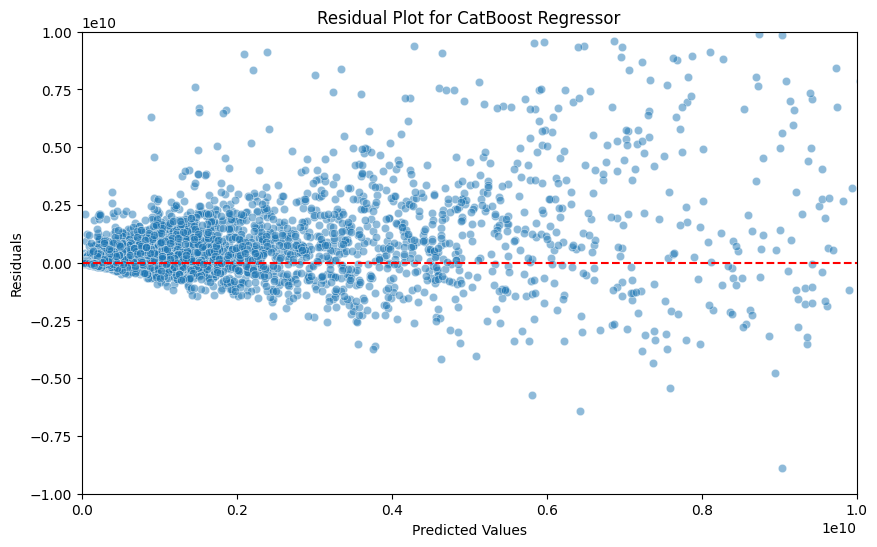

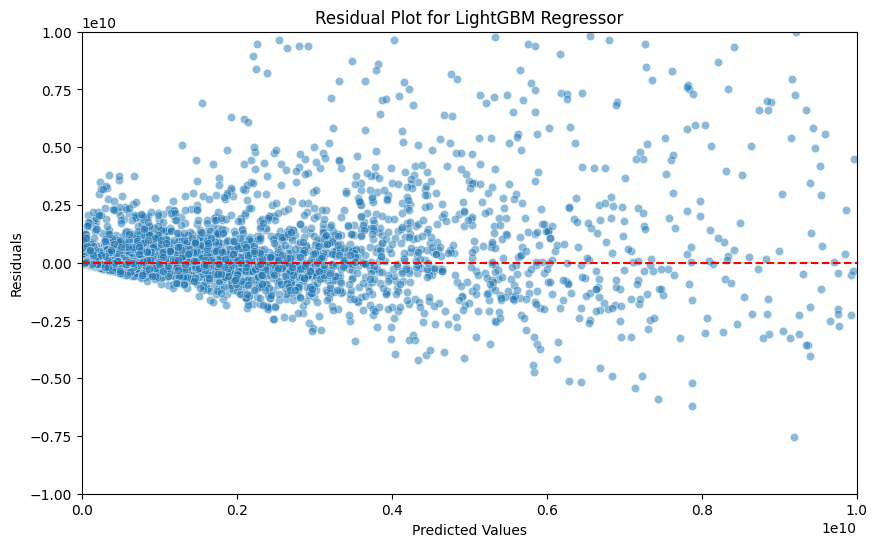

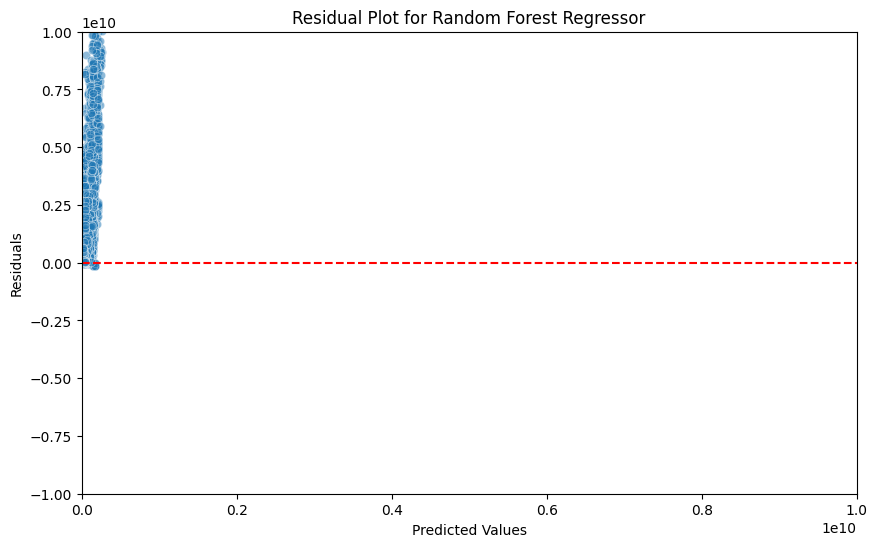

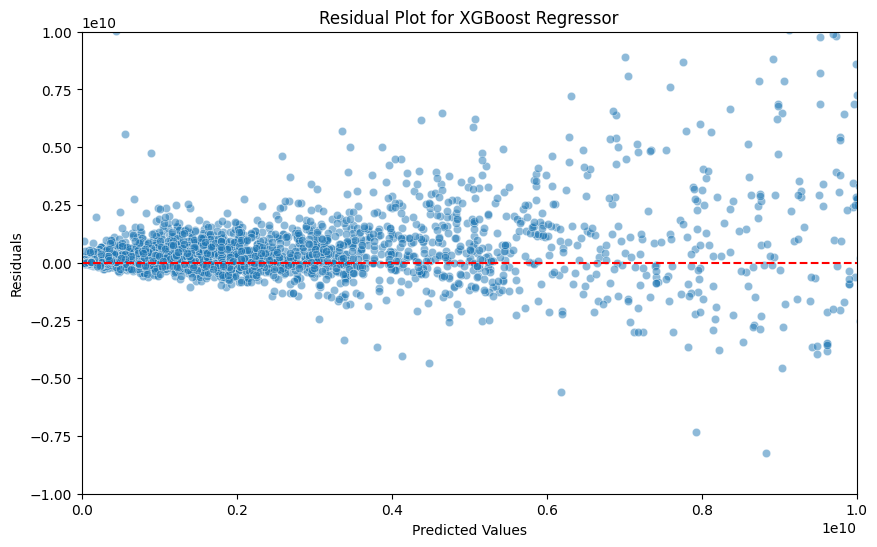

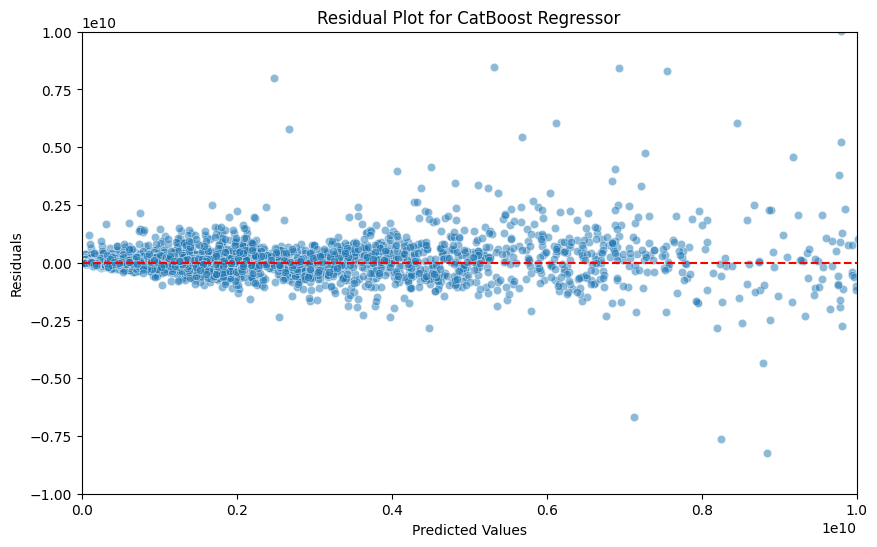

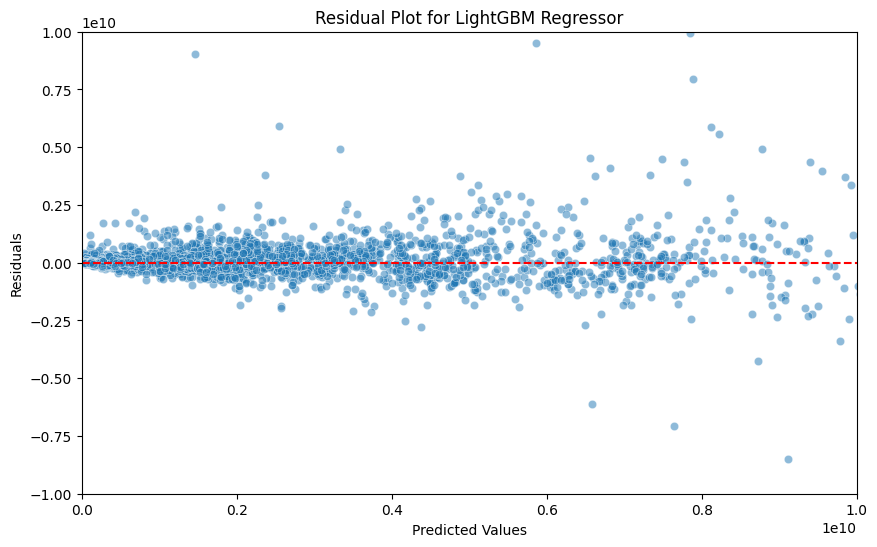

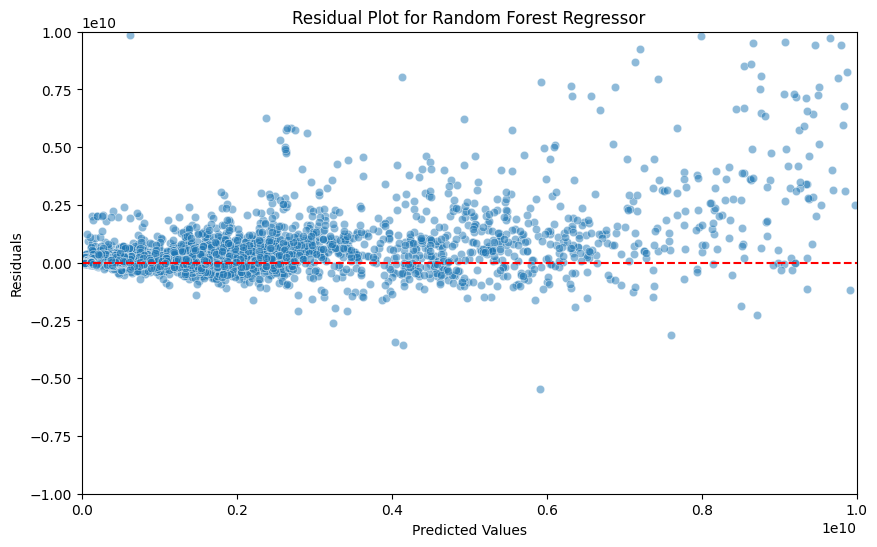

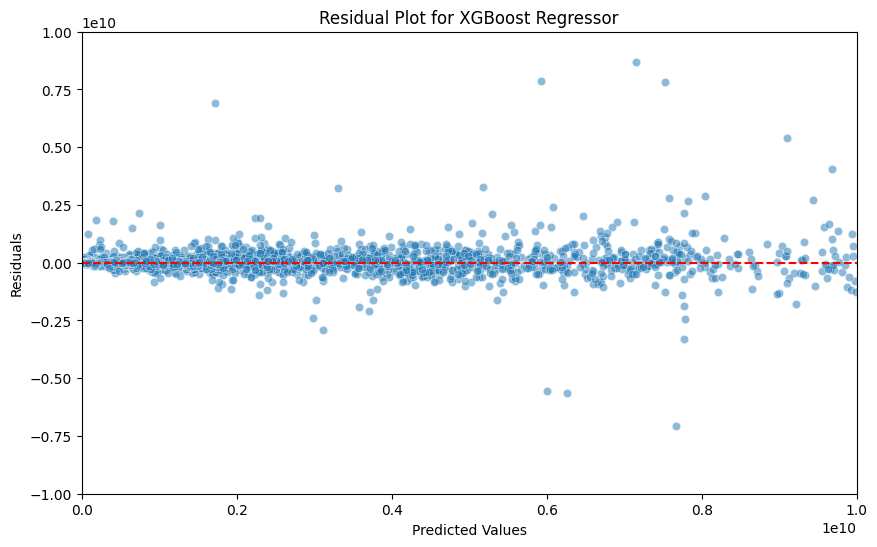

In [133]:
# Function to load all models from a directory
def load_models(directory):
    models = {}
    for filename in os.listdir(directory):
        if filename.endswith(".joblib"):
            model_name = filename.replace(".joblib", "").replace("_", " ")
            model_path = os.path.join(directory, filename)
            models[model_name] = joblib.load(model_path)
            print(f"Loaded {model_name} from {model_path}")
    return models

# Function to make predictions with a model
def make_predictions(models, X):
    predictions = {model_name: np.expm1(model.predict(X)) for model_name, model in models.items()}
    return predictions

# Function to plot residuals using seaborn
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.xlim(0, 1e10)
    plt.ylim(-1e10, 1e10)
    plt.show()

# Load trained models
models_one_hot = load_models("saved_models_one_hot")
models_feature_eng = load_models("saved_models_feature_engineering")

# Prepare the validation data
X_validation = data.drop('co2directscope1_raw', axis=1)
y_validation = np.expm1(data['co2directscope1_raw'])

# Make predictions
predictions_one_hot = make_predictions(models_one_hot, X_validation)
predictions_feature_eng = make_predictions(models_feature_eng, X_validation)

# Plot residuals for all models
for model_name, preds in predictions_one_hot.items():
    plot_residuals(y_validation, preds, model_name)
for model_name, preds in predictions_feature_eng.items():
    plot_residuals(y_validation, preds, model_name)


# Validation Data

#### Loading Data
Loading both training and validation datasets to prepare for feature engineering and merging.

In [118]:
# Load the data
validation_data = pd.read_csv('validation_data.csv')  # data to backfill
full_data = pd.read_csv('data.csv')  # data with all the engineered features

# Log transformation on Revenue feature
validation_data['revenue'] = np.log1p(validation_data['revenue'])

# Replace NaN values in the 'revenue' column with the values from 'company_revenue_mean'
full_data['revenue'] = full_data['revenue'].fillna(full_data['company_revenue_mean'])

#### Integrating Company, Industry, and Country Level Features into the Validation Dataset
Extracting and merging company, industry and country level features from the training data into the validation dataset.

In [119]:
# Company-level features
company_and_change_features = train_data[['clarity_id', 'company_co2_mean', 'company_co2_std', 'company_revenue_mean', 'company_revenue_std', 'co2_percent_change', 'revenue_percent_change']].drop_duplicates(subset=['clarity_id'])
validation_data = validation_data.merge(company_and_change_features, on='clarity_id', how='left')

# Industry-level features
industry_features = full_data[['clarity_industry_name', 'industry_co2_mean', 'industry_co2_std', 'industry_revenue_mean', 'industry_revenue_std']].drop_duplicates(subset=['clarity_industry_name'])
validation_data = validation_data.merge(industry_features, on='clarity_industry_name', how='left')

# Country-level features
country_features = full_data[['country_code', 'country_co2_mean', 'country_co2_std', 'country_revenue_mean', 'country_revenue_std']].drop_duplicates(subset=['country_code'])
validation_data = validation_data.merge(country_features, on='country_code', how='left')

# Sorting
validation_data.sort_values(by=['clarity_id', 'metric_year'], inplace=True)

#### Imputing Missing Values in CO2 and Revenue Percent Changes
Addressing missing values after merging in the 'CO2 percent change' and 'Revenue percent change' features within the validation dataset. Using a previously trained Random Forest model, the missing values are filled to ensure the dataset is complete.

In [120]:
# Replace NaN in 'company_co2_std' and 'company_revenue_std' with 0
validation_data['company_co2_std'] = validation_data['company_co2_std'].fillna(0) # There is only one row with one single observation
validation_data['company_revenue_std'] = validation_data['company_revenue_std'].fillna(0)

# Defining the feature columns used during model training
features_columns = data.drop(columns=['clarity_id', 'metric', 'clarity_industry_code', 'clarity_industry_name', 
                             'country_code', 'co2directscope1_raw', 'co2directscope1_intensity',
                             'co2_percent_change', 'revenue_percent_change']).columns.tolist()

# Predict and impute missing CO2 percent changes in validation data
X_missing_co2_validation = validation_data[validation_data['co2_percent_change'].isna()][features_columns]
X_missing_co2_preprocessed_validation = pipeline_rf.transform(X_missing_co2_validation)
predicted_co2_validation = rf_model_co2.predict(X_missing_co2_preprocessed_validation)
validation_data.loc[validation_data['co2_percent_change'].isna(), 'co2_percent_change'] = predicted_co2_validation

# Predict and impute missing Revenue percent changes in validation data
X_missing_revenue_validation = validation_data[validation_data['revenue_percent_change'].isna()][features_columns]
X_missing_revenue_preprocessed_validation = pipeline_rf.transform(X_missing_revenue_validation)
predicted_revenue_validation = rf_model_revenue.predict(X_missing_revenue_preprocessed_validation)
validation_data.loc[validation_data['revenue_percent_change'].isna(), 'revenue_percent_change'] = predicted_revenue_validation


In [121]:
validation_data

,clarity_id,metric,metric_year,provider_code,clarity_industry_code,clarity_industry_name,country_code,revenue,targets_emissions,policy_emissions,...,co2_percent_change,revenue_percent_change,industry_co2_mean,industry_co2_std,industry_revenue_mean,industry_revenue_std,country_co2_mean,country_co2_std,country_revenue_mean,country_revenue_std
138,01FF543RHED3HMK8JZ1Y4KEFSA,CO2DIRECTSCOPE1,2022,TRC8,30202030/0,Packaged Foods & Meats,JP,13.262195,1,1,...,0.000343,0.008577,17.444089,1.548170,13.558285,1.208481,17.477287,2.286303,13.752087,1.100000
225,01FF543RJ22VSA2QF6BW9QR4A4,CO2DIRECTSCOPE1,2022,TRC8,55100000/1,Electricity generation utilities,US,14.812465,0,1,...,-0.000750,0.008004,21.029721,2.483183,13.653335,1.148367,17.582486,2.906038,14.242827,1.334786
231,01FF543RJ56BSZRF8X8F7HB7Z5,CO2DIRECTSCOPE1,2019,TRC1,60201020/0,Real Estate Operating Companies,CH,10.819718,1,1,...,-0.002004,0.005844,12.477768,2.187272,10.471206,0.738359,15.917686,2.302631,13.829806,1.379734
57,01FF543RJ5PNCNB23H778CSF67,CO2DIRECTSCOPE1,2021,TRC8,45202030/0,"Technology Hardware, Storage & Peripherals",TW,13.511310,1,1,...,0.001628,0.007798,15.400569,2.001940,14.422086,1.218930,15.623797,2.366360,13.596988,1.036963
9,01FF543RJWEY942NE6BJ1CD0ME,CO2DIRECTSCOPE1,2015,TRC1,15101030/0,Fertilizers & Agricultural Chemicals,CA,14.429417,1,1,...,-0.001109,0.003479,18.913092,1.801897,13.434319,0.937101,18.136061,2.479924,13.274095,1.215071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,01FF543WQ70YCVRD498N8ZAX9G,CO2DIRECTSCOPE1,2022,TRC8,30201030/0,Soft Drinks & Non-alcoholic Beverages,TR,12.922903,1,1,...,0.000038,0.010502,17.389539,1.450088,13.775246,1.430221,14.812656,0.744801,11.434880,2.082410
204,01FF543WQ72GC1W7DA9FNHNKNN,CO2DIRECTSCOPE1,2021,TRC8,30202030/0,Packaged Foods & Meats,US,14.168481,1,0,...,-0.000465,0.006754,17.444089,1.548170,13.558285,1.208481,17.582486,2.906038,14.242827,1.334786
176,01FF543WQG4HA299HP76X4N377,CO2DIRECTSCOPE1,2020,TRC1,10102040/0,Oil & Gas Storage & Transportation,MH,12.332595,1,1,...,-0.003705,-0.000727,19.499602,1.507517,13.705385,1.069897,20.193218,0.085179,12.496983,0.205877
120,01FF543WQJBYAQE73ER2P0XMP5,CO2DIRECTSCOPE1,2019,TRC1,20103010/0,Construction & Engineering,GB,13.413861,1,1,...,-0.000385,0.003724,17.331218,1.719294,13.758425,0.925594,15.768761,2.798520,12.753413,1.734429


### Making Predictions and Reverting Log Transformations
Utilizing the ensemble models trained earlier to generate predictions for the validation dataset. After making these predictions, the predictions are converted from the logarithmic scale back to their original scale.

In [122]:
# Making predictions
predictions_one_hot = make_predictions(models_one_hot, validation_data)
predictions_feature_eng = make_predictions(models_feature_eng, validation_data)

# Store raw predictions in the validation DataFrame
for model, predictions in predictions_one_hot.items():
    validation_data[f"{model} (one_hot_raw)"] = predictions

for model, predictions in predictions_feature_eng.items():
    validation_data[f"{model} (feature_eng_raw)"] = predictions

### Saving the Final Dataset
Saving the backfilled validation dataset to a CSV file

In [123]:
# Save the final DataFrame to a CSV file
validation_data.to_csv('backfilled_validation(Michael).csv', index=False)